## Set Up Environment

In [230]:
# import libraries
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from matplotlib import pyplot as plt
from sklearn.metrics import r2_score
from xgboost import XGBRegressor
from scipy import stats
import seaborn as sns
import pandas as pd
import numpy as np
import os

In [231]:
# read data
df_trainRaw = pd.read_csv("train.csv")
df_testRaw = pd.read_csv("test.csv")
# read data
df_trainNew = pd.read_csv("train_new.csv")
df_testNew = pd.read_csv("test_new.csv")

df_trainRaw["O"] = df_trainNew["O"]
df_trainRaw["P"] = df_trainNew["P"]

df_testRaw["O"] = df_testNew["O"]
df_testRaw["P"] = df_testNew["P"]

In [232]:
# config 
responders = list(df_trainRaw.columns[-4:-2])
predictors = list(df_trainRaw.columns[1:-4])+["O","P"]

# manual config
out_of_sample_split = 60000

In [233]:
# train and evaluation
df_inSampleRaw = df_trainRaw.loc[df_trainRaw.time <= out_of_sample_split]
df_outSampleRaw = df_trainRaw.loc[df_trainRaw.time > out_of_sample_split]

## Causal Evaluation Pipeline

In [234]:
# causal prediction 
def causalPrediction(currTime, dt, model, df, predictors=predictors, responder="Y1", model_name="", timeCol="time", trainResponder=""):
    if trainResponder=="":
        trainResponder = responder

    # fit model
    df_train = df.loc[df[timeCol] < currTime].copy()
    model.fit(df_train[predictors], df_train[trainResponder])

    # extract times
    targetTimes = df[timeCol]
    targetTimes = targetTimes.loc[targetTimes >= currTime]
    targetTimes = targetTimes.loc[targetTimes < currTime + dt]
    # add predictions
    df.loc[df[timeCol].isin(targetTimes) ,f"{responder}_pred_{model_name}"] = model.predict(df.loc[df[timeCol].isin(targetTimes)][predictors])

def autoPredict(respond, model, model_name, df, dt=10000, predictors=predictors, trainResponder=""):
    # extract time splits
    times = (df.time//dt * dt).drop_duplicates().iloc[1:]

    # test
    for time in times:
        causalPrediction(time, dt, model, df, model_name=model_name, responder=respond, predictors=predictors, trainResponder=trainResponder)

def autoEval(respond, model, model_name, df, dt=10000, minTrainTime=20000, timeCol="time", predictors=predictors, trainResponder=""):
    autoPredict(respond, model, model_name, df, dt=dt, predictors=predictors, trainResponder=trainResponder)

    # calculate r2
    df_eval = df.loc[df[timeCol] >= minTrainTime].dropna()
    return r2_score(df_eval[respond], df_eval[f"{respond}_pred_{model_name}"])

# new auto prediction
respond = "Y1"
xgb_base = XGBRegressor(n_estimators=40, learning_rate=0.08)
autoPredict("Y1", xgb_base, "base", df_inSampleRaw, dt=10000)
autoPredict("Y2", xgb_base, "base", df_inSampleRaw, dt=10000)

C:\Users\andyd\AppData\Local\Temp\ipykernel_49200\919287829.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[timeCol].isin(targetTimes) ,f"{responder}_pred_{model_name}"] = model.predict(df.loc[df[timeCol].isin(targetTimes)][predictors])
C:\Users\andyd\AppData\Local\Temp\ipykernel_49200\919287829.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[timeCol].isin(targetTimes) ,f"{responder}_pred_{model_name}"] = model.predict(df.loc[df[timeCol].isin(targetTimes)][predictors])


In [235]:
# good enough model
xgb_base = XGBRegressor(n_estimators=40, learning_rate=0.08)
autoEval(respond, xgb_base, "base", df_inSampleRaw)

0.7713002371721571

## Diagnose Base XGB model

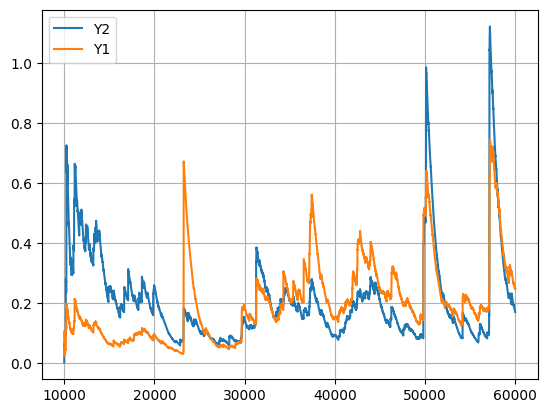

In [236]:
# error vs time
respond = "Y2"
df_baseEval = df_inSampleRaw[[respond, f"{respond}_pred_base"]].copy()
df_baseEval["residualBase"]  = (df_baseEval[respond] - df_baseEval[f"{respond}_pred_base"]) ** 2
df_baseEval["ewmse"] = df_baseEval["residualBase"].ewm(span=2000).mean()
df_baseEval["ewmse"].plot()
plt.grid(True)

respond = "Y1"
df_baseEval = df_inSampleRaw[[respond, f"{respond}_pred_base"]].copy()
df_baseEval["residualBase"]  = (df_baseEval[respond] - df_baseEval[f"{respond}_pred_base"]) ** 2
df_baseEval["ewmse"] = df_baseEval["residualBase"].ewm(span=2000).mean()
df_baseEval["ewmse"].plot()
plt.grid(True)

plt.legend(["Y2", "Y1"])

In [237]:
# short eval
r2_score(df_baseEval.dropna()[respond], df_baseEval.dropna()[f"{respond}_pred_base"])

0.7446431127080735

In [238]:
# wide spread eval
xgb_base.fit(df_inSampleRaw[predictors], df_inSampleRaw[respond])
r2_score(df_outSampleRaw[respond], xgb_base.predict(df_outSampleRaw[predictors]))

0.7031582396980066

## Y2 Autocorrelation

In [239]:
df_Y2_autoReg = df_inSampleRaw.copy()
df_Y2_autoReg["t-1_Y2_pred"] = df_Y2_autoReg["Y2_pred_base"].shift(1)
df_Y2_autoReg["t-2_Y2_pred"] = df_Y2_autoReg["Y2_pred_base"].shift(2)
df_Y2_autoReg = df_Y2_autoReg.dropna()
autoPredictors = predictors+["t-1_Y2_pred", "t-2_Y2_pred", "Y1_pred_base"]
autoPredict("Y2", xgb_base, "auto", df_Y2_autoReg, dt=10000, predictors=autoPredictors)

In [240]:
df_evalY2_auto = df_Y2_autoReg.dropna().copy()
print(r2_score(df_evalY2_auto.Y2, df_evalY2_auto.Y2_pred_base))
print(r2_score(df_evalY2_auto.Y2, df_evalY2_auto.Y2_pred_auto))

0.6245342642510943
0.6206133199434072


In [241]:
autoEval("Y2", xgb_base, "auto", df_Y2_autoReg, dt=10000, predictors=autoPredictors)

0.6206133199434072

In [242]:
# see past winning competition submissions for how people fine tuned their cat boost, xgboost etc. 

# fine tune xgboost hyperparameters
# engineer better features, based on understanding of how xgboost works

## Feature Selection

In [243]:
# Good enough model
respond = "Y2"
xgb_base = XGBRegressor(n_estimators=40, learning_rate=0.08)
autoEval(respond, xgb_base, "base", df_inSampleRaw)

0.6245342642510943

In [244]:
# backward selection
def backwardSelection(respond, model, name, df, features):
    oldR2 = autoEval(respond, model, name, df, predictors=features)
    bestR2 = oldR2

    # first iteration
    for feature in features:
        reducedFeatures = features.copy()
        reducedFeatures.remove(feature)
        currR2 = autoEval(respond, model, name, df, predictors=reducedFeatures)
        if currR2 > bestR2:
            bestR2 = currR2
            worstFeature = feature

    # next iteration
    while (bestR2 > oldR2):
        oldR2 = bestR2
        print("best R2: "+str(bestR2))
        features.remove(worstFeature)
        print("removed "+worstFeature)

        # re-iteration
        for feature in features:
            reducedFeatures = features.copy()
            reducedFeatures.remove(feature)
            currR2 = autoEval(respond, model, name, df, predictors=reducedFeatures)
            if currR2 > bestR2:
                bestR2 = currR2
                worstFeature = feature

    return features

In [245]:
# starting predictors
respond = "Y1"
Y1_best_predictors = predictors.copy()

# execute
Y1_best_features = backwardSelection(respond, xgb_base, "auto", df_inSampleRaw, Y1_best_predictors)

C:\Users\andyd\AppData\Local\Temp\ipykernel_49200\919287829.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[timeCol].isin(targetTimes) ,f"{responder}_pred_{model_name}"] = model.predict(df.loc[df[timeCol].isin(targetTimes)][predictors])


best R2: 0.7807372305755671
removed A
best R2: 0.7845785836985958
removed F


In [246]:
# starting predictors
respond = "Y2"
Y2_best_predictors = predictors.copy()

# execute
Y2_best_features = backwardSelection(respond, xgb_base, "base", df_inSampleRaw, Y2_best_predictors)

best R2: 0.6358847387113884
removed F
best R2: 0.6468464315473306
removed H


In [247]:
# wide spread eval
respond = "Y1"
xgb_base.fit(df_inSampleRaw[Y1_best_features], df_inSampleRaw[respond])
r2_score(df_outSampleRaw[respond], xgb_base.predict(df_outSampleRaw[Y1_best_features]))

0.6979202199060883

In [248]:
# wide spread eval
respond = "Y2"
xgb_base.fit(df_inSampleRaw[Y2_best_features], df_inSampleRaw[respond])
r2_score(df_outSampleRaw[respond], xgb_base.predict(df_outSampleRaw[Y2_best_features]))

0.5345502901305239

In [249]:
autoPredict("Y1", xgb_base, "base", df_inSampleRaw, dt=10000, predictors=Y1_best_features)
autoPredict("Y2", xgb_base, "base", df_inSampleRaw, dt=10000, predictors=Y2_best_features)

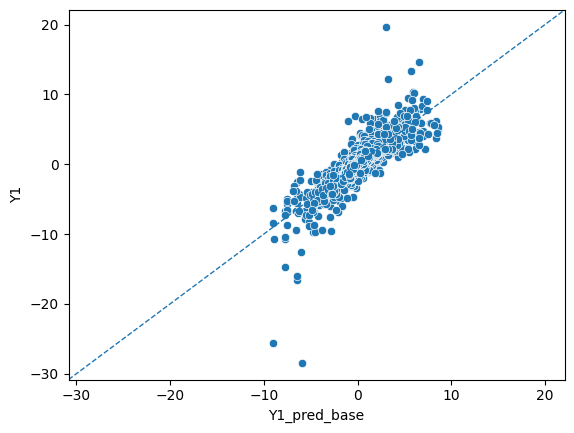

In [250]:
ax = sns.scatterplot(df_inSampleRaw, x="Y1_pred_base", y="Y1")
x0, x1 = ax.get_xlim()
y0, y1 = ax.get_ylim()
lims = [min(x0, y0), max(x1, y1)]
ax.plot(lims, lims, linestyle="--", linewidth=1)
ax.set_xlim(lims); ax.set_ylim(lims)
plt.show()

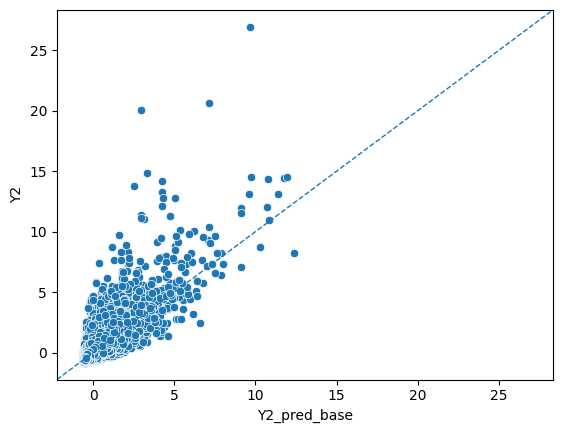

In [251]:
ax = sns.scatterplot(df_inSampleRaw, x="Y2_pred_base", y="Y2")
x0, x1 = ax.get_xlim()
y0, y1 = ax.get_ylim()
lims = [min(x0, y0), max(x1, y1)]
ax.plot(lims, lims, linestyle="--", linewidth=1)
ax.set_xlim(lims); ax.set_ylim(lims)
plt.show()

## Short submission

In [183]:
# train
xgb_base.fit(df_trainRaw[Y1_best_features], df_trainRaw["Y1"])
df_testRaw["Y1"] = xgb_base.predict(df_testRaw[Y1_best_features])
xgb_base.fit(df_trainRaw[Y2_best_features], df_trainRaw["Y2"])
df_testRaw["Y2"] = xgb_base.predict(df_testRaw[Y2_best_features])

In [ ]:
sub_col = ["id","Y1","Y2"]
df_sub = df_testRaw[sub_col]
df_sub.to_csv("basic_xgb.csv", index=False)

## Linear Regression

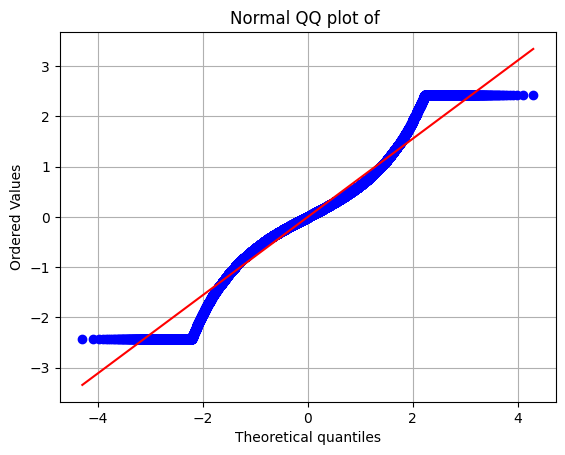

In [188]:
def QQnorm(series, col_name=""):
    norm = np.asarray(series)  
    fig = plt.figure()
    res = stats.probplot(norm, dist="norm", plot=plt)
    plt.title(f"Normal QQ plot of {col_name}")
    plt.grid(True)
    plt.show()    

# Y1 kurtosis management (ACAUSAL)
df_Y1 = df_trainRaw[["Y1"]].copy()
df_Y1["std"] = df_Y1["Y1"].std()
df_Y1["Y1_clip"] = df_Y1["Y1"]

clip_std = 2.5
# clip above 
df_Y1["Y1_clip"] += (df_Y1["Y1_clip"] > clip_std * df_Y1["std"]) * (clip_std * df_Y1["std"] - df_Y1["Y1_clip"])
df_Y1["Y1_clip"] += (df_Y1["Y1_clip"] < -clip_std * df_Y1["std"]) * (-clip_std * df_Y1["std"] - df_Y1["Y1_clip"])

# QQ plot of clip
QQnorm(df_Y1.Y1_clip)

In [192]:
df_inSampleClip = df_inSampleRaw.copy()
df_inSampleClip["Y1_clip"] = df_Y1.Y1_clip

In [ ]:
lin_model = LinearRegression()
respond = "Y1"
print(autoEval(respond, lin_model, "lin", df_inSampleClip))
print(autoEval(respond, lin_model, "lin", df_inSampleClip, trainResponder="Y1_clip"))

0.7643693513537423
0.7236712485941477


In [ ]:
respond = "Y2"
print(autoEval(respond, lin_model, "lin", df_inSampleClip))

0.5741560833298698


In [207]:
# wide spread eval
respond = "Y1"
lin_model.fit(df_inSampleClip[predictors], df_inSampleClip[respond])
r2_score(df_outSampleRaw[respond], lin_model.predict(df_outSampleRaw[predictors]))

0.7113703538184952

In [ ]:
respond = "Y1"
Y1_lin_predictors = predictors.copy()
Y1_lin_features = backwardSelection(respond, lin_model, "lin", df_inSampleRaw, Y1_lin_predictors)

C:\Users\andyd\AppData\Local\Temp\ipykernel_49200\919287829.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[timeCol].isin(targetTimes) ,f"{responder}_pred_{model_name}"] = model.predict(df.loc[df[timeCol].isin(targetTimes)][predictors])


best R2: 0.7644209230699854
removed K
best R2: 0.7644845698729295
removed F


In [213]:
# model stacking
df_Y1_linStack = df_inSampleRaw.copy()
linStackPredictors = predictors+["Y1_pred_lin"]
autoPredict("Y1", xgb_base, "linStack", df_Y1_linStack, dt=10000, predictors=linStackPredictors)

In [214]:
df_evalY1_linStack = df_Y1_linStack.dropna().copy()
print(r2_score(df_evalY1_linStack.Y1, df_evalY1_linStack.Y1_pred_lin))
print(r2_score(df_evalY1_linStack.Y1, df_evalY1_linStack.Y1_pred_base))
print(r2_score(df_evalY1_linStack.Y1, df_evalY1_linStack.Y1_pred_linStack))


0.7633212831750743
0.7462438003741498
0.745491673410225


## Lin Sub

In [216]:
# train
lin_model.fit(df_trainRaw[predictors], df_trainRaw["Y1"])
df_testRaw["Y1"] = lin_model.predict(df_testRaw[predictors])
xgb_base.fit(df_trainRaw[predictors], df_trainRaw["Y2"])
df_testRaw["Y2"] = xgb_base.predict(df_testRaw[predictors])

sub_col = ["id","Y1","Y2"]
df_sub = df_testRaw[sub_col]
df_sub.to_csv("lin_model.csv", index=False)

## Capture Autocorrelation

In [220]:
# train and evaluation
massPredictors = predictors.copy()
df_inSampleAuto = df_trainRaw.loc[df_trainRaw.time <= out_of_sample_split]
df_outSampleAuto = df_trainRaw.loc[df_trainRaw.time > out_of_sample_split]
for predictor in predictors:
    massPredictors.append(predictor+"_t-1")
    df_inSampleAuto[predictor+"_t-1"] = df_inSampleAuto[predictor].shift(1)

C:\Users\andyd\AppData\Local\Temp\ipykernel_49200\1955646587.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_inSampleAuto[predictor+"_t-1"] = df_inSampleAuto[predictor].shift(1)
C:\Users\andyd\AppData\Local\Temp\ipykernel_49200\1955646587.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_inSampleAuto[predictor+"_t-1"] = df_inSampleAuto[predictor].shift(1)
C:\Users\andyd\AppData\Local\Temp\ipykernel_49200\1955646587.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

In [ ]:
print(autoEval("Y2", xgb_base, "mass", df_inSampleAuto))
print(autoEval("Y1", xgb_base, "mass", df_inSampleAuto))

0.6933248244644921


C:\Users\andyd\AppData\Local\Temp\ipykernel_49200\919287829.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[timeCol].isin(targetTimes) ,f"{responder}_pred_{model_name}"] = model.predict(df.loc[df[timeCol].isin(targetTimes)][predictors])


0.7380841216049068


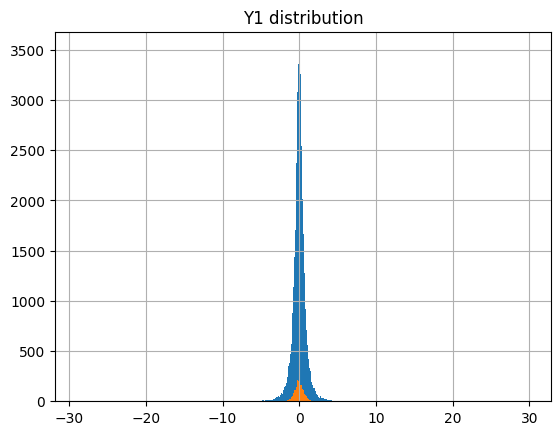

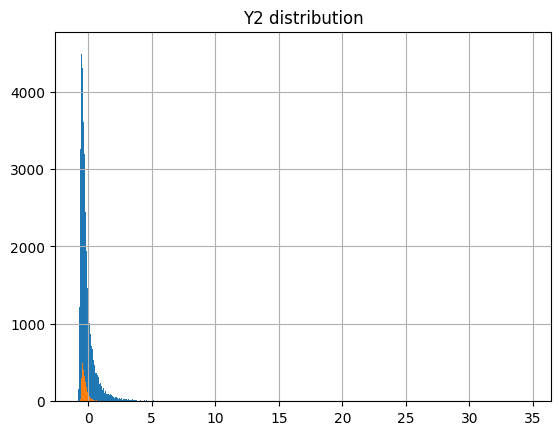

In [225]:
# visualise distributions
for responder in responders:
    plt.title(responder+" distribution")
    plt.hist(df_trainRaw[responder], bins=1000)
    plt.hist(df_testRaw[responder], bins=1000)
    plt.grid(True)
    plt.show()

## Data Scaling

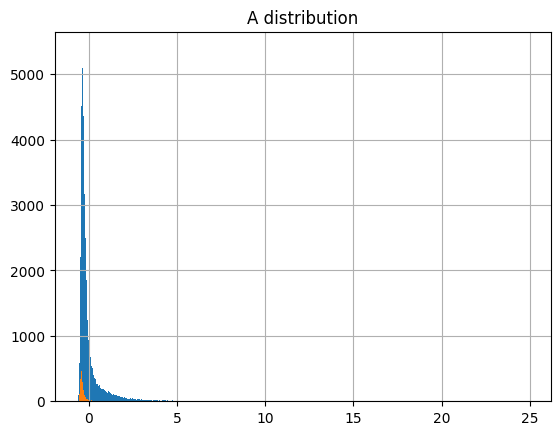

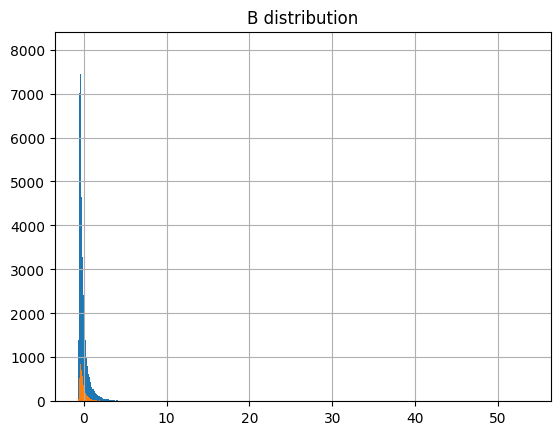

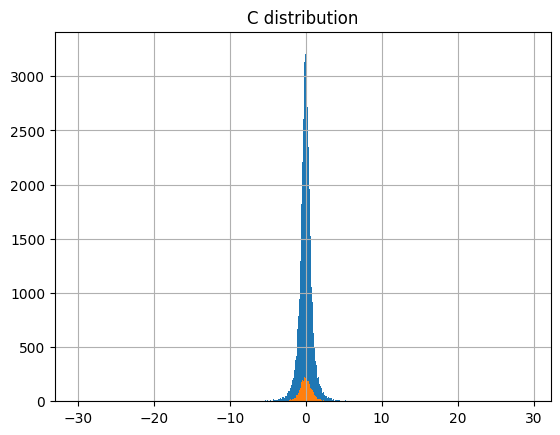

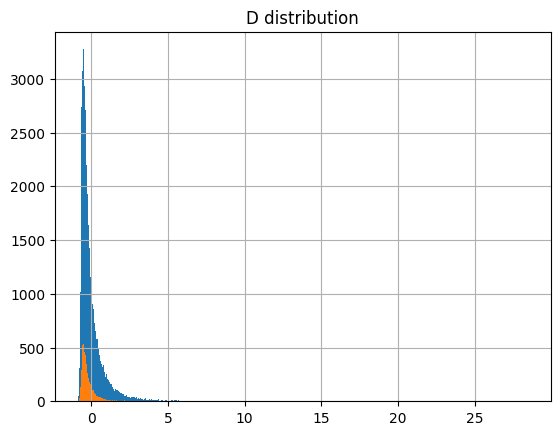

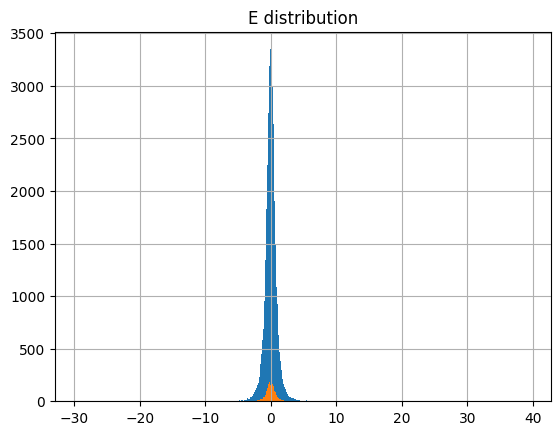

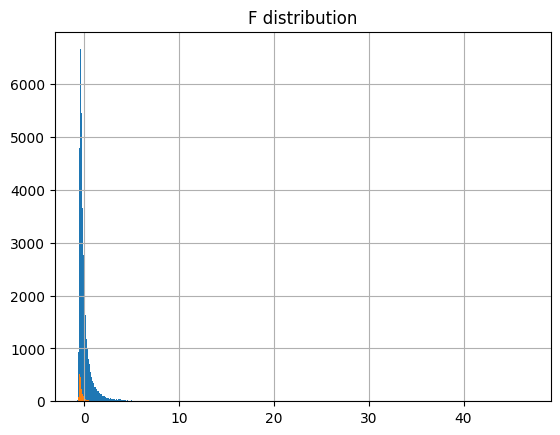

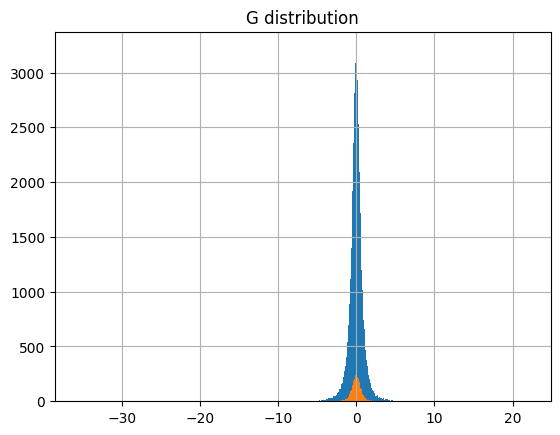

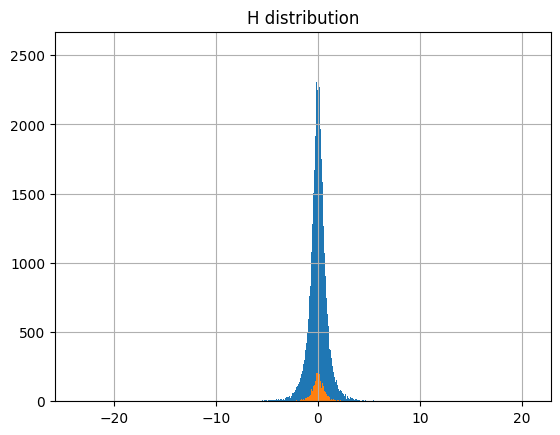

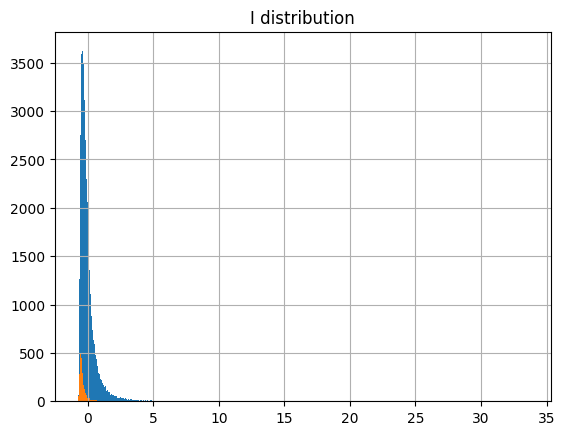

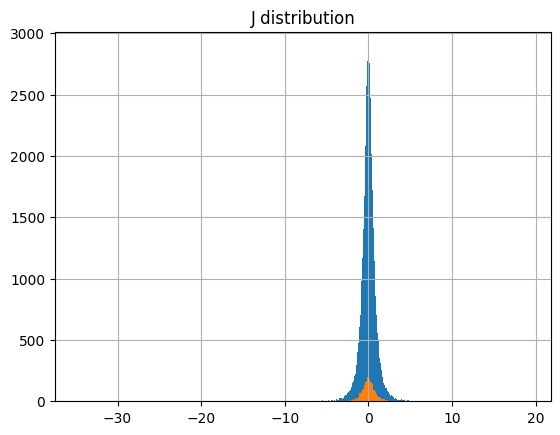

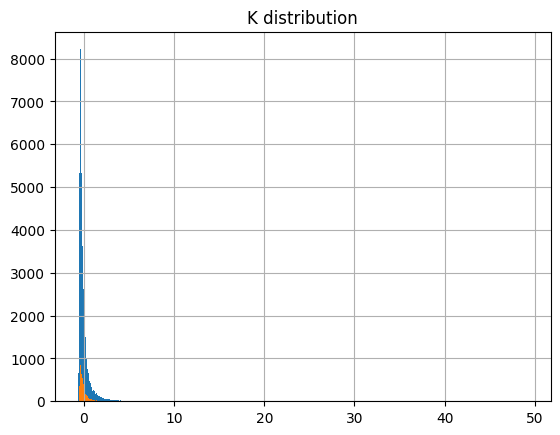

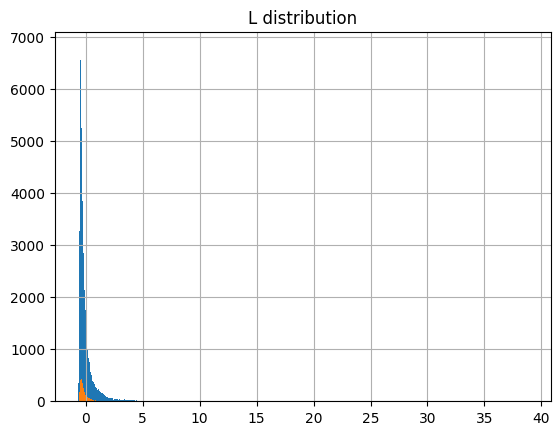

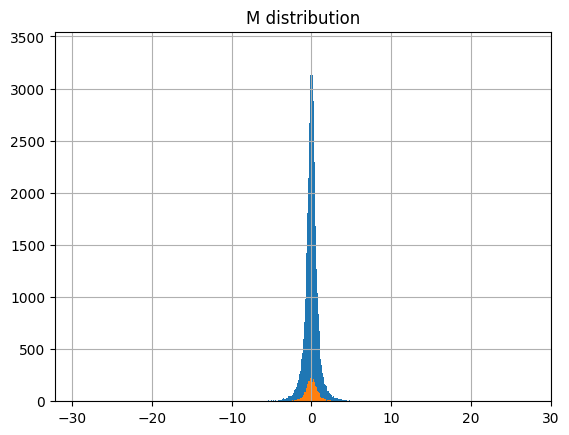

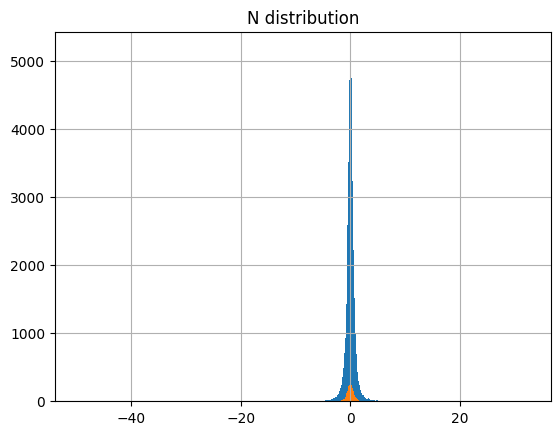

In [227]:
# visualise distributions
for predictor in predictors:
    plt.title(predictor+" distribution")
    plt.hist(df_trainRaw[predictor], bins=1000)
    plt.hist(df_testRaw[predictor], bins=1000)
    plt.grid(True)
    plt.show()